# Insurance Risk Score prediction


## 1. Importing Libraries

In [1]:
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
import numpy as np

### Creating spark session

In [2]:
spark = SparkSession.builder.appName("Insurance Prediction").getOrCreate()
spark

## 2. Loading Data

In [3]:
data = spark.read.csv("./data/insurance.csv", header=True, inferSchema=True)
data.show()

+-------------------+------------------+--------+------+-------------+------------------+-------+----------+
|Monthly Installment|Insurance Category|Diabetes|Smoker|User Category|               Job|College|Risk Score|
+-------------------+------------------+--------+------+-------------+------------------+-------+----------+
|                800|            Health|     Yes|    No|   Individual|          Engineer|    Yes|       Low|
|                950|              Life|      No|   Yes|       Family|           Teacher|    Yes|      High|
|               1200|              Auto|      No|    No|   Individual|            Doctor|    Yes|    Medium|
|                700|            Health|     Yes|   Yes|       Family| Marketing Manager|    Yes|      High|
|                850|              Life|      No|    No|       Family|        Accountant|    Yes|       Low|
|               1100|              Auto|     Yes|    No|   Individual|Software Developer|     No|    Medium|
|                75

In [4]:
# Exploratory Data Analysis (EDA) using pandas
df = pd.read_csv("./data/insurance.csv")
df.head()

,Monthly Installment,Insurance Category,Diabetes,Smoker,User Category,Job,College,Risk Score
0,800,Health,Yes,No,Individual,Engineer,Yes,Low
1,950,Life,No,Yes,Family,Teacher,Yes,High
2,1200,Auto,No,No,Individual,Doctor,Yes,Medium
3,700,Health,Yes,Yes,Family,Marketing Manager,Yes,High
4,850,Life,No,No,Family,Accountant,Yes,Low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Monthly Installment  69 non-null     int64 
 1   Insurance Category   69 non-null     object
 2   Diabetes             69 non-null     object
 3   Smoker               69 non-null     object
 4   User Category        69 non-null     object
 5   Job                  69 non-null     object
 6   College              69 non-null     object
 7   Risk Score           69 non-null     object
dtypes: int64(1), object(7)
memory usage: 4.4+ KB


In [6]:
df.describe()

,Monthly Installment
count,69.000000
mean,929.710145
std,153.011159
min,680.000000
25%,800.000000
50%,920.000000
75%,1050.000000
max,1220.000000


### Checking for null values

In [7]:
df.isnull().sum()

Monthly Installment    0
Insurance Category     0
Diabetes               0
Smoker                 0
User Category          0
Job                    0
College                0
Risk Score             0
dtype: int64

In [8]:
data.printSchema()

root
 |-- Monthly Installment: integer (nullable = true)
 |-- Insurance Category: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- User Category: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- College: string (nullable = true)
 |-- Risk Score: string (nullable = true)



## 3. Exploratory Data Analysis

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Temp\ipykernel_11304\2344453832.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Risk Score', palette='viridis')


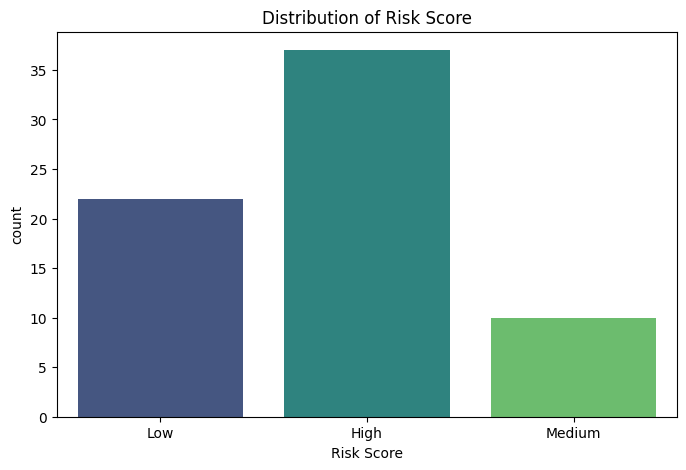

In [10]:
# Plotting the distribution of the target variable - Risk Score
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Risk Score', palette='viridis')
plt.title('Distribution of Risk Score')
plt.show()

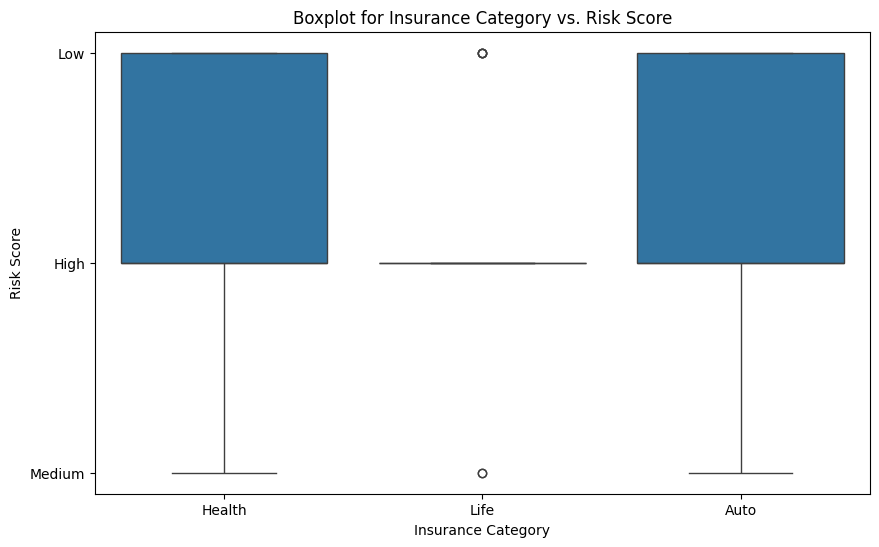

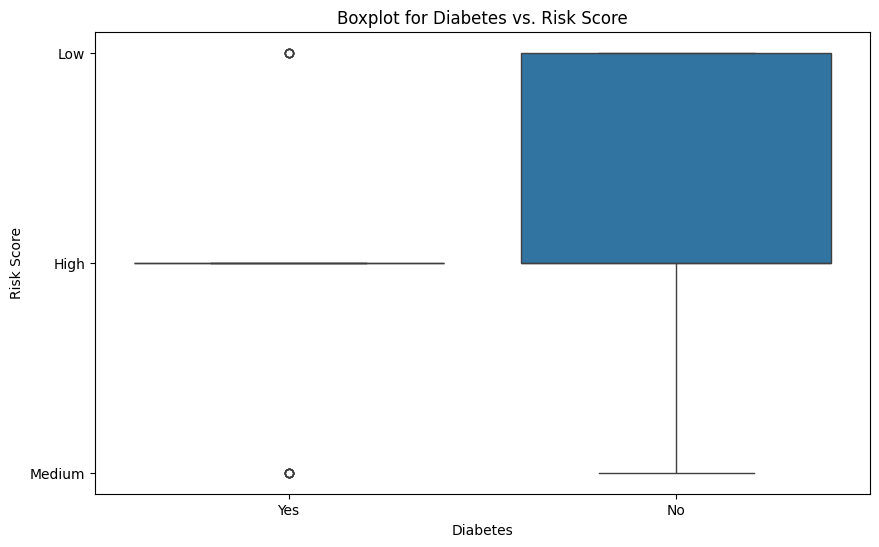

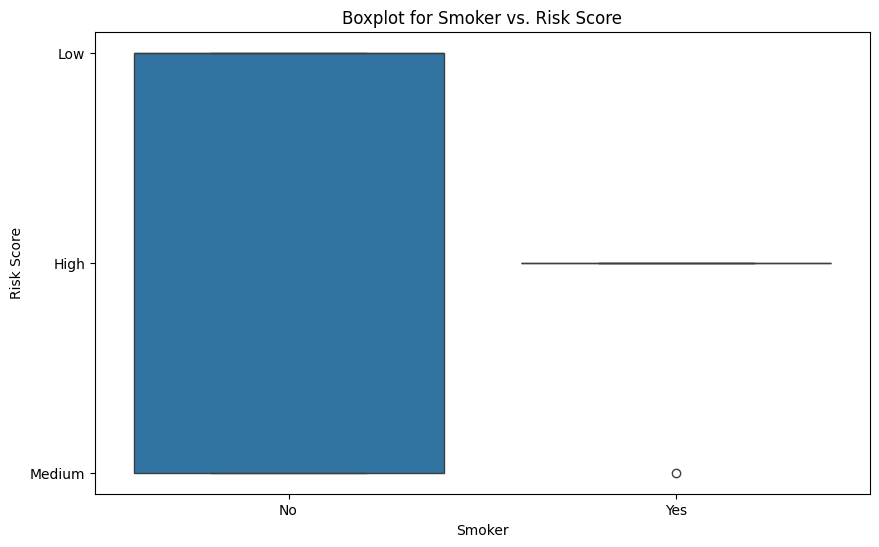

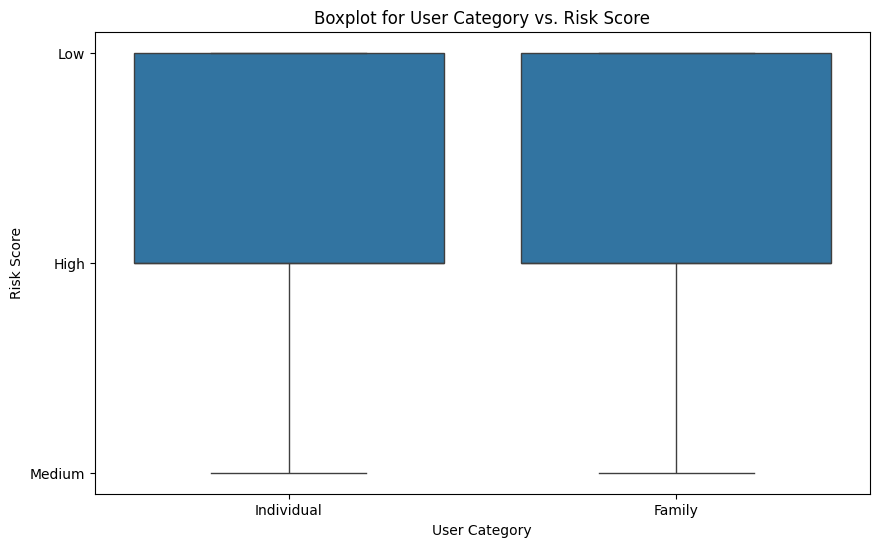

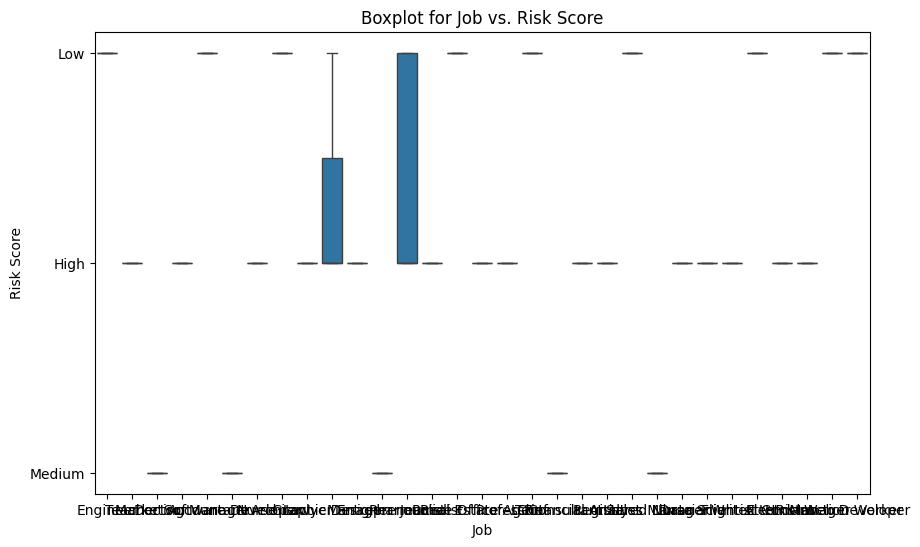

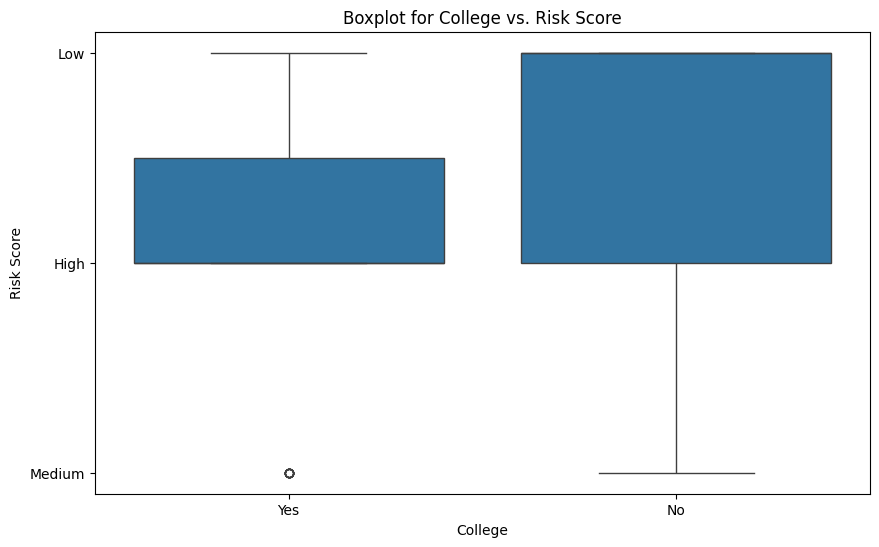

In [11]:
# Boxplot for categorical variables vs. Risk Score
categorical_columns = ["Insurance Category", "Diabetes", "Smoker", "User Category", "Job", "College"]
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, y='Risk Score', data=df)
    plt.title(f'Boxplot for {column} vs. Risk Score')
    plt.show()

## 4. Data Preprocessing

### Perform StringIndexing for categorical variables


In [12]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data)
            for column in ["Insurance Category", "Diabetes", "Smoker", "User Category", "Job", "College", "Risk Score"]]
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)

### Create feature vector 

In [13]:
assembler = VectorAssembler(inputCols=["Monthly Installment", "Insurance Category_index", "Diabetes_index",
                            "Smoker_index", "User Category_index", "Job_index", "College_index"], outputCol="features")
data = assembler.transform(data)

In [14]:
# Display the updated schema to identify the correct label column
data.printSchema()

root
 |-- Monthly Installment: integer (nullable = true)
 |-- Insurance Category: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- User Category: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- College: string (nullable = true)
 |-- Risk Score: string (nullable = true)
 |-- Insurance Category_index: double (nullable = false)
 |-- Diabetes_index: double (nullable = false)
 |-- Smoker_index: double (nullable = false)
 |-- User Category_index: double (nullable = false)
 |-- Job_index: double (nullable = false)
 |-- College_index: double (nullable = false)
 |-- Risk Score_index: double (nullable = false)
 |-- features: vector (nullable = true)



### Split data into train and test sets


In [15]:
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=42)
print(f"Training Dataset Count: {train_data.count()}")
print(f"Test Dataset Count: {test_data.count()}")

Training Dataset Count: 40
Test Dataset Count: 29


In [16]:
data.columns

['Monthly Installment',
 'Insurance Category',
 'Diabetes',
 'Smoker',
 'User Category',
 'Job',
 'College',
 'Risk Score',
 'Insurance Category_index',
 'Diabetes_index',
 'Smoker_index',
 'User Category_index',
 'Job_index',
 'College_index',
 'Risk Score_index',
 'features']

## 5. Model Building (Random Forest)

In [17]:
# Train Random Forest Classifier
rf = RandomForestClassifier(
    labelCol="Risk Score_index", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

## 6. Model Evaluation

In [18]:
predictions = model.transform(test_data)

In [19]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(
    labelCol="Risk Score_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"\nModel accuracy: {accuracy*100:.4f}%")


Model accuracy: 96.5517%


In [20]:
# Classification report
y_true = predictions.select("Risk Score_index").toPandas()
y_pred = predictions.select("prediction").toPandas()
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      0.92      0.96        12
         2.0       0.67      1.00      0.80         2

    accuracy                           0.97        29
   macro avg       0.89      0.97      0.92        29
weighted avg       0.98      0.97      0.97        29



In [21]:
spark.stop()